***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml
import shap

import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador


In [5]:
SEED = 19
SUB_NBR = str(max([int(fn.split("/")[-1].split(".")[0][3:]) for fn in glob(f"{subs_path}/*")])+1)
print(SUB_NBR)

17


In [6]:
np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [7]:
with open(f"../data/skus_assess_m1.yaml", "r") as file:
    skus_assess_m1 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m1): {len(skus_assess_m1)}")
    file.close()

with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m2): {len(skus_assess_m2)}")
    file.close()
    
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
print(f"len(skus_for_test): {len(skus_for_test)}")

len(skus_assess_m1): 482635
len(skus_assess_m2): 272130
len(skus_for_test): 551472


In [10]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    
    #skus_assess_m1 = set(skus_assess_m1) & set(skus_for_test)
    #print("# skus assess & test:", len(skus_assess_m1))

    dataset = (
        pd.read_parquet(f"{input_path}/train-m1.parquet")
        .query("sku in @skus_assess_m1")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )

In [11]:
if ASSESS:
    raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
    metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
    raw = pd.merge(raw, metadata, how="inner", on="sku")

    # compute q_mean and q_std features (w/o leakage)
    feat = Featurador(raw)
    feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
    dataset = feat.transform(dataset)

In [12]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()
    
# use dist_config of best submission
dist_config = dict(
    beta = 0.634505,
    lambda1 = 0.458712,
    lambda2 = 0.967726,
)
print(dist_config)

{'beta': 0.634505, 'lambda1': 0.458712, 'lambda2': 0.967726}


***
## model config

In [13]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,7,]),
        "std":    (None, [1,], [3,7]),
    },
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 110.75 Mb (52.0% reduction)
Mem. usage decreased to 115.40 Mb (52.0% reduction)
Elapsed time for processing features: 1.346618115901947 min.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 1209701, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.804359
[100]	valid_0's rmsse: 0.758539
[150]	valid_0's rmsse: 0.753121
Early stopping, best iteration is:
[159]	valid_0's rmsse: 0.752869


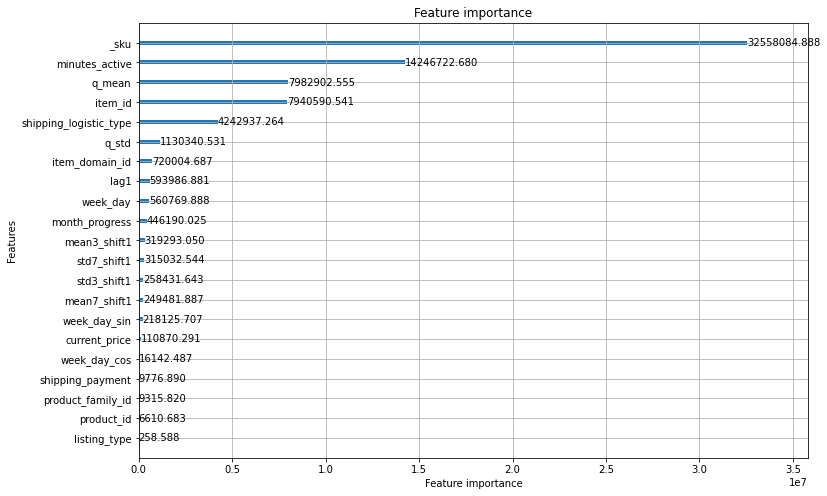

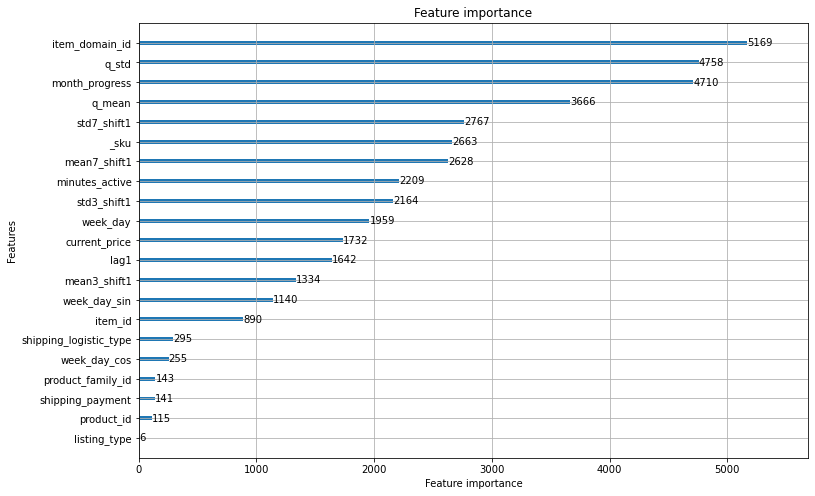

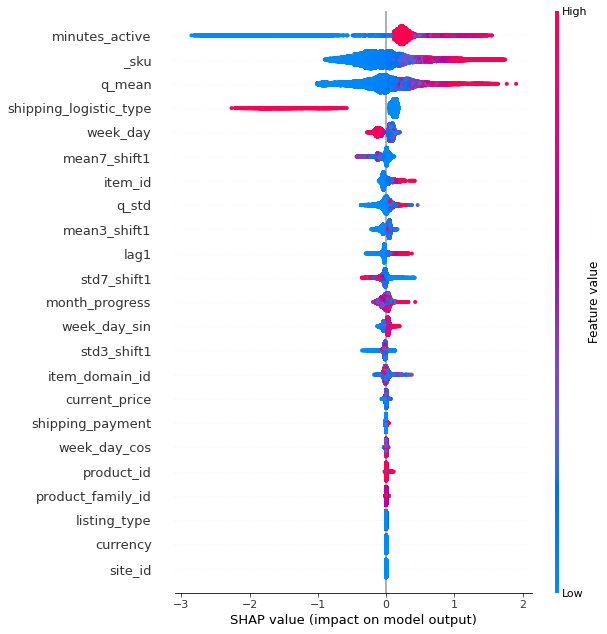

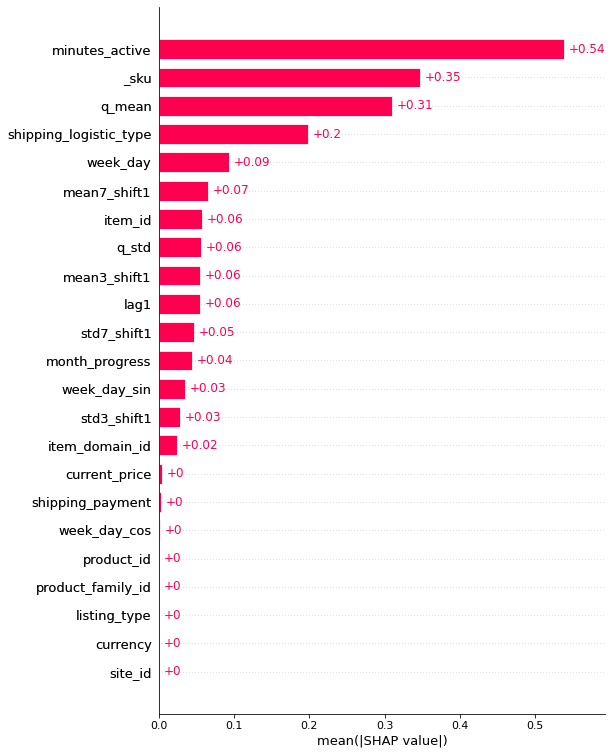

Elapsed time for training the model: 3.497353899478912 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 646.92 Mb (52.0% reduction)
Mem. usage decreased to 673.03 Mb (52.0% reduction)
Elapsed time for processing features: 3.232226248582204 min.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 7066070, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.846368
[100]	valid_0's rmsse: 0.794318
[150]	valid_0's rmsse: 0.786686
[200]	valid_0's rmsse: 0.786192
Early stopping, best iteration is:
[179]	valid_0's rmsse: 0.785745


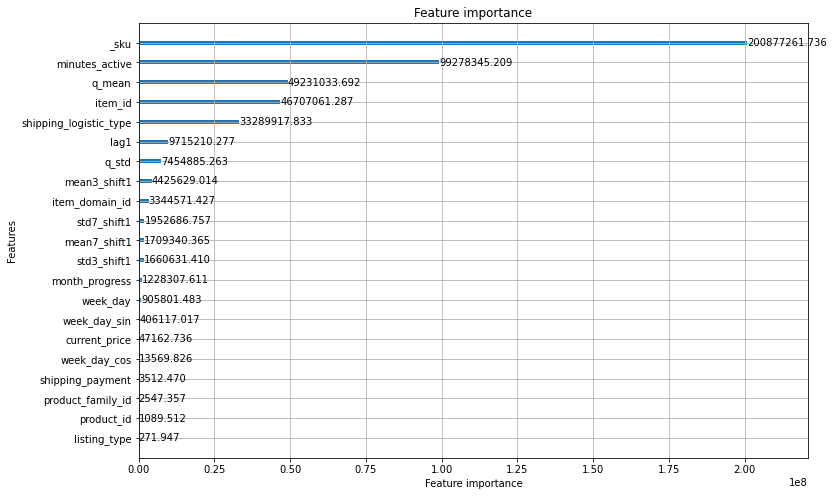

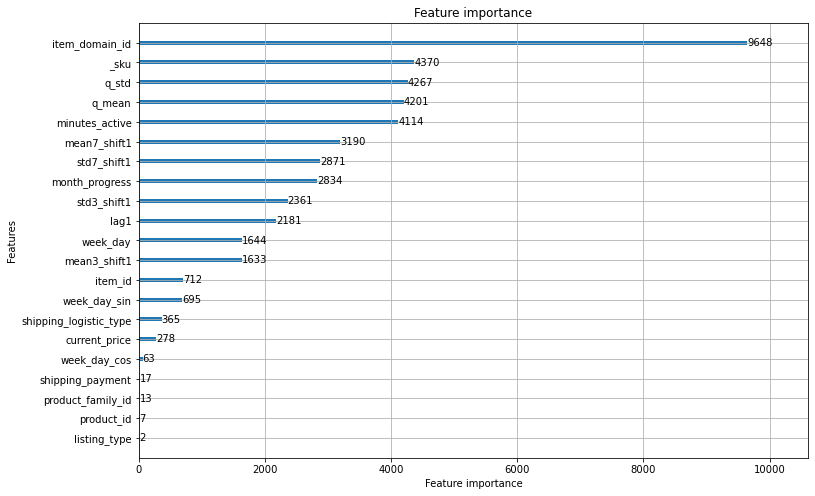

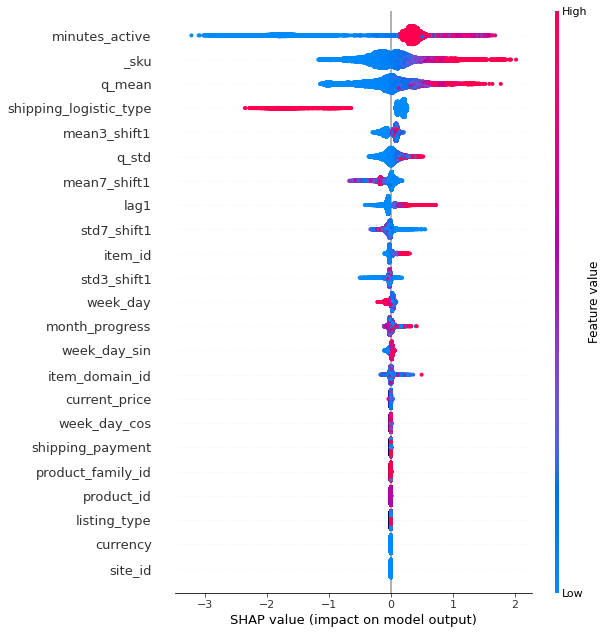

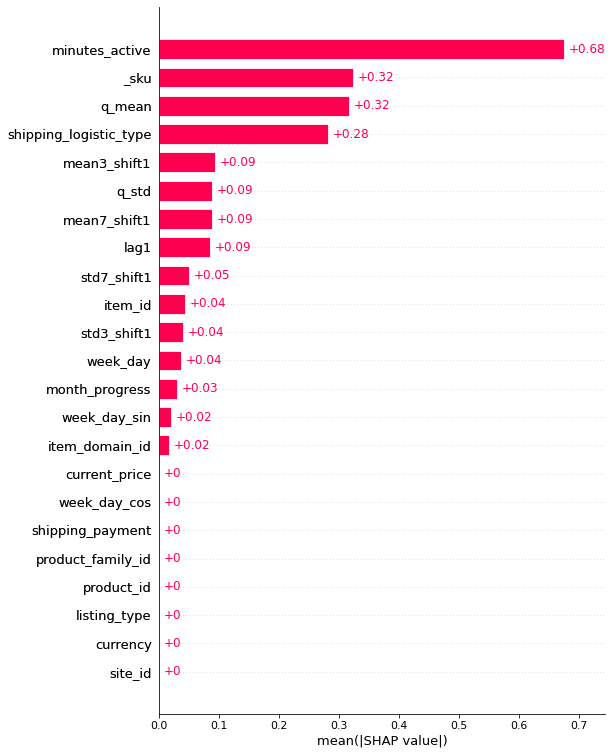

Elapsed time for training the model: 4.83231154680252 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 514.35 Mb (52.0% reduction)
Mem. usage decreased to 537.17 Mb (52.0% reduction)
Elapsed time for processing features: 2.6724865714708965 min.
[LightGBM] [Info] Total Bins 3000
[LightGBM] [Info] Number of data points in the train set: 5618024, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.801837
[100]	valid_0's rmsse: 0.750413
[150]	valid_0's rmsse: 0.743162
[200]	valid_0's rmsse: 0.743135
Early stopping, best iteration is:
[177]	valid_0's rmsse: 0.742552


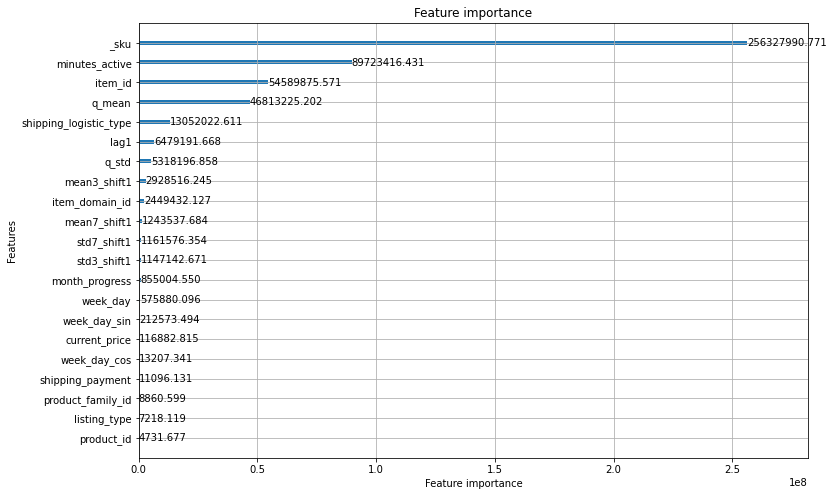

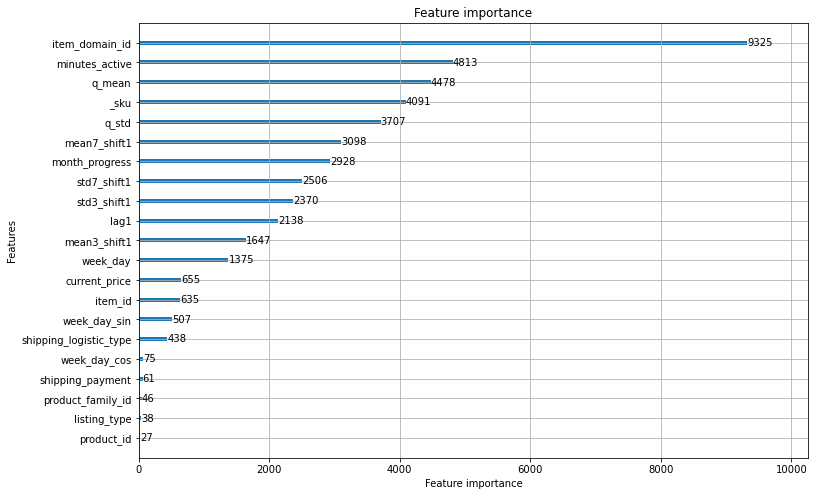

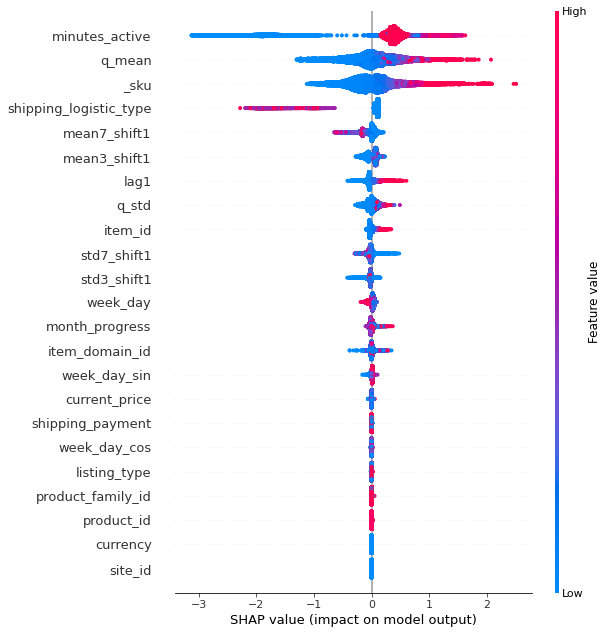

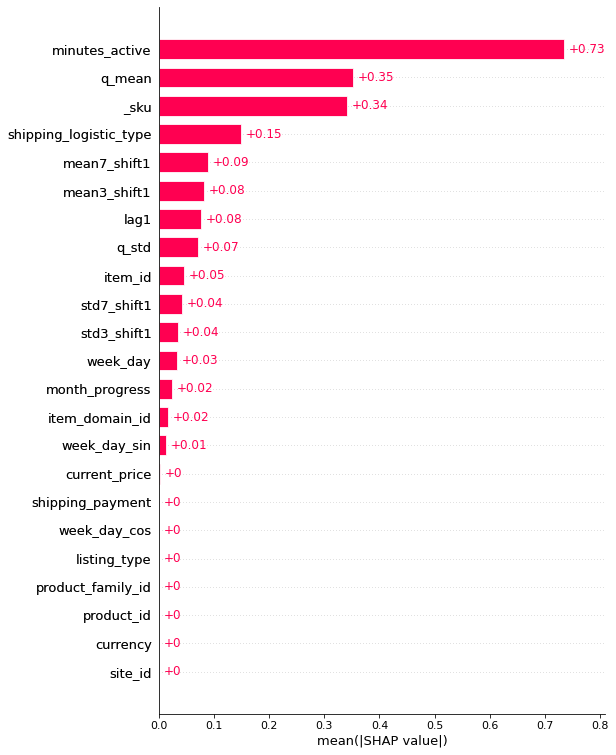

Elapsed time for training the model: 4.271792284647623 min.


{'rmsse_MLA': 0.7528689495800679,
 'rmsse_MLB': 0.7857447306630239,
 'rmsse_MLM': 0.7425517643305308,
 'rmsse_AVG': 0.760388481524541}

In [14]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
        
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
        lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
        plt.show()
        explainer = shap.Explainer(model.model.model)
        shap_values = explainer(model.valid_features[model.input_features].sample(30000))
        shap.plots.beeswarm(shap_values, max_display=23, show=True)
        shap.plots.bar(shap_values, max_display=23, show=True)

        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")
        
    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)


In [15]:
if ASSESS:
    # calculates fit stats on train dataset
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
        all_preds.append(preds)
    train_preds = pd.concat(all_preds, axis=0, ignore_index=True)
    train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    
    train_preds["abs_error"] = train_preds.eval("abs(y-y_pred)")
    train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
    train_preds["residual"] = train_preds.eval("(y-y_pred)")

    rmse = np.sqrt(train_preds.groupby(["sku"])["sq_error"].mean()).reset_index(name="rmse")
    mean_ae = train_preds.groupby(["sku"])["abs_error"].mean().reset_index(name="mean_ae")
    median_ae = train_preds.groupby(["sku"])["abs_error"].median().reset_index(name="median_ae")
    residual_std = train_preds.groupby(["sku"])["residual"].std().reset_index(name="residual_std")
    residual_mad = train_preds.groupby(["sku"])["residual"].mad().reset_index(name="residual_mad")

    fit_stats = (
        rmse
        .merge(mean_ae, how="inner", on="sku")
        .merge(median_ae, how="inner", on="sku")
        .merge(residual_std, how="inner", on="sku")
        .merge(residual_mad, how="inner", on="sku")
        .merge(scales, how="inner", on="sku")
        .merge(dataset[["sku","site_id","q_mean"]].drop_duplicates(subset=["sku"]), how="inner", on="sku")
    )
    fit_stats["rmsse"] = fit_stats.eval("rmse / scale")
    fit_stats["rmse_norm"] = fit_stats.eval("rmse / q_mean")
    fit_stats["mean_ae_norm"] = fit_stats.eval("mean_ae / q_mean")
    fit_stats["median_ae_norm"] = fit_stats.eval("median_ae / q_mean")
    fit_stats["residual_std_norm"] = fit_stats.eval("residual_std / q_mean")
    fit_stats["residual_mad_norm"] = fit_stats.eval("residual_mad / q_mean")
    fit_stats["scale_norm"] = fit_stats.eval("scale / q_mean")
    display(fit_stats.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.667958
MLB    0.681615
MLM    0.705549
Name: rmsse, dtype: float64

In [16]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 14min 43s, sys: 57.5 s, total: 15min 41s
Wall time: 26min 8s


In [17]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.759407
MLB    0.799167
MLM    0.757636
Name: rmsse, dtype: float64

In [18]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)
    fit_stats.to_csv(f"{results_path}/train_errors_lgbm-m1-stg1.csv", index=False)

***
## Assessment of invetory days prediction

In [19]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 482635/482635 [01:02<00:00, 7671.10it/s]


In [20]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_seed2_harder.csv")
        .query("sku in @skus_assess_m1")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)
    valid["days_to_stockout_disc"] = valid["days_to_stockout"].astype(int)

100%|██████████| 482635/482635 [00:57<00:00, 8412.10it/s]


RMSE (mean):  9.395255900278446
MAE (mean):  6.7683483691263495
MAE (median):  4.632482656312934



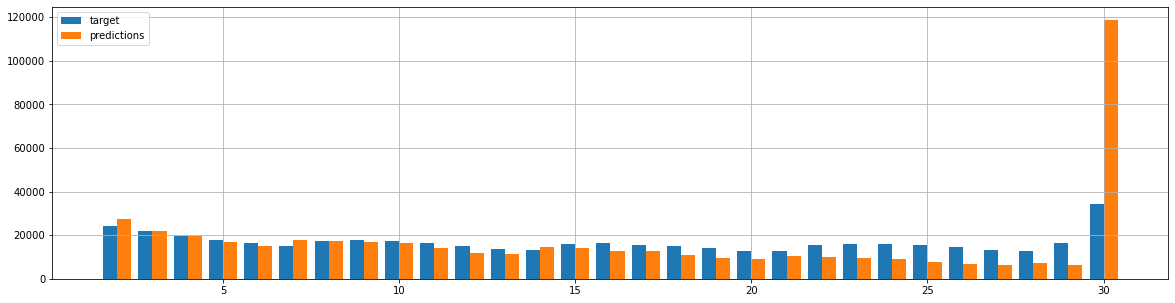

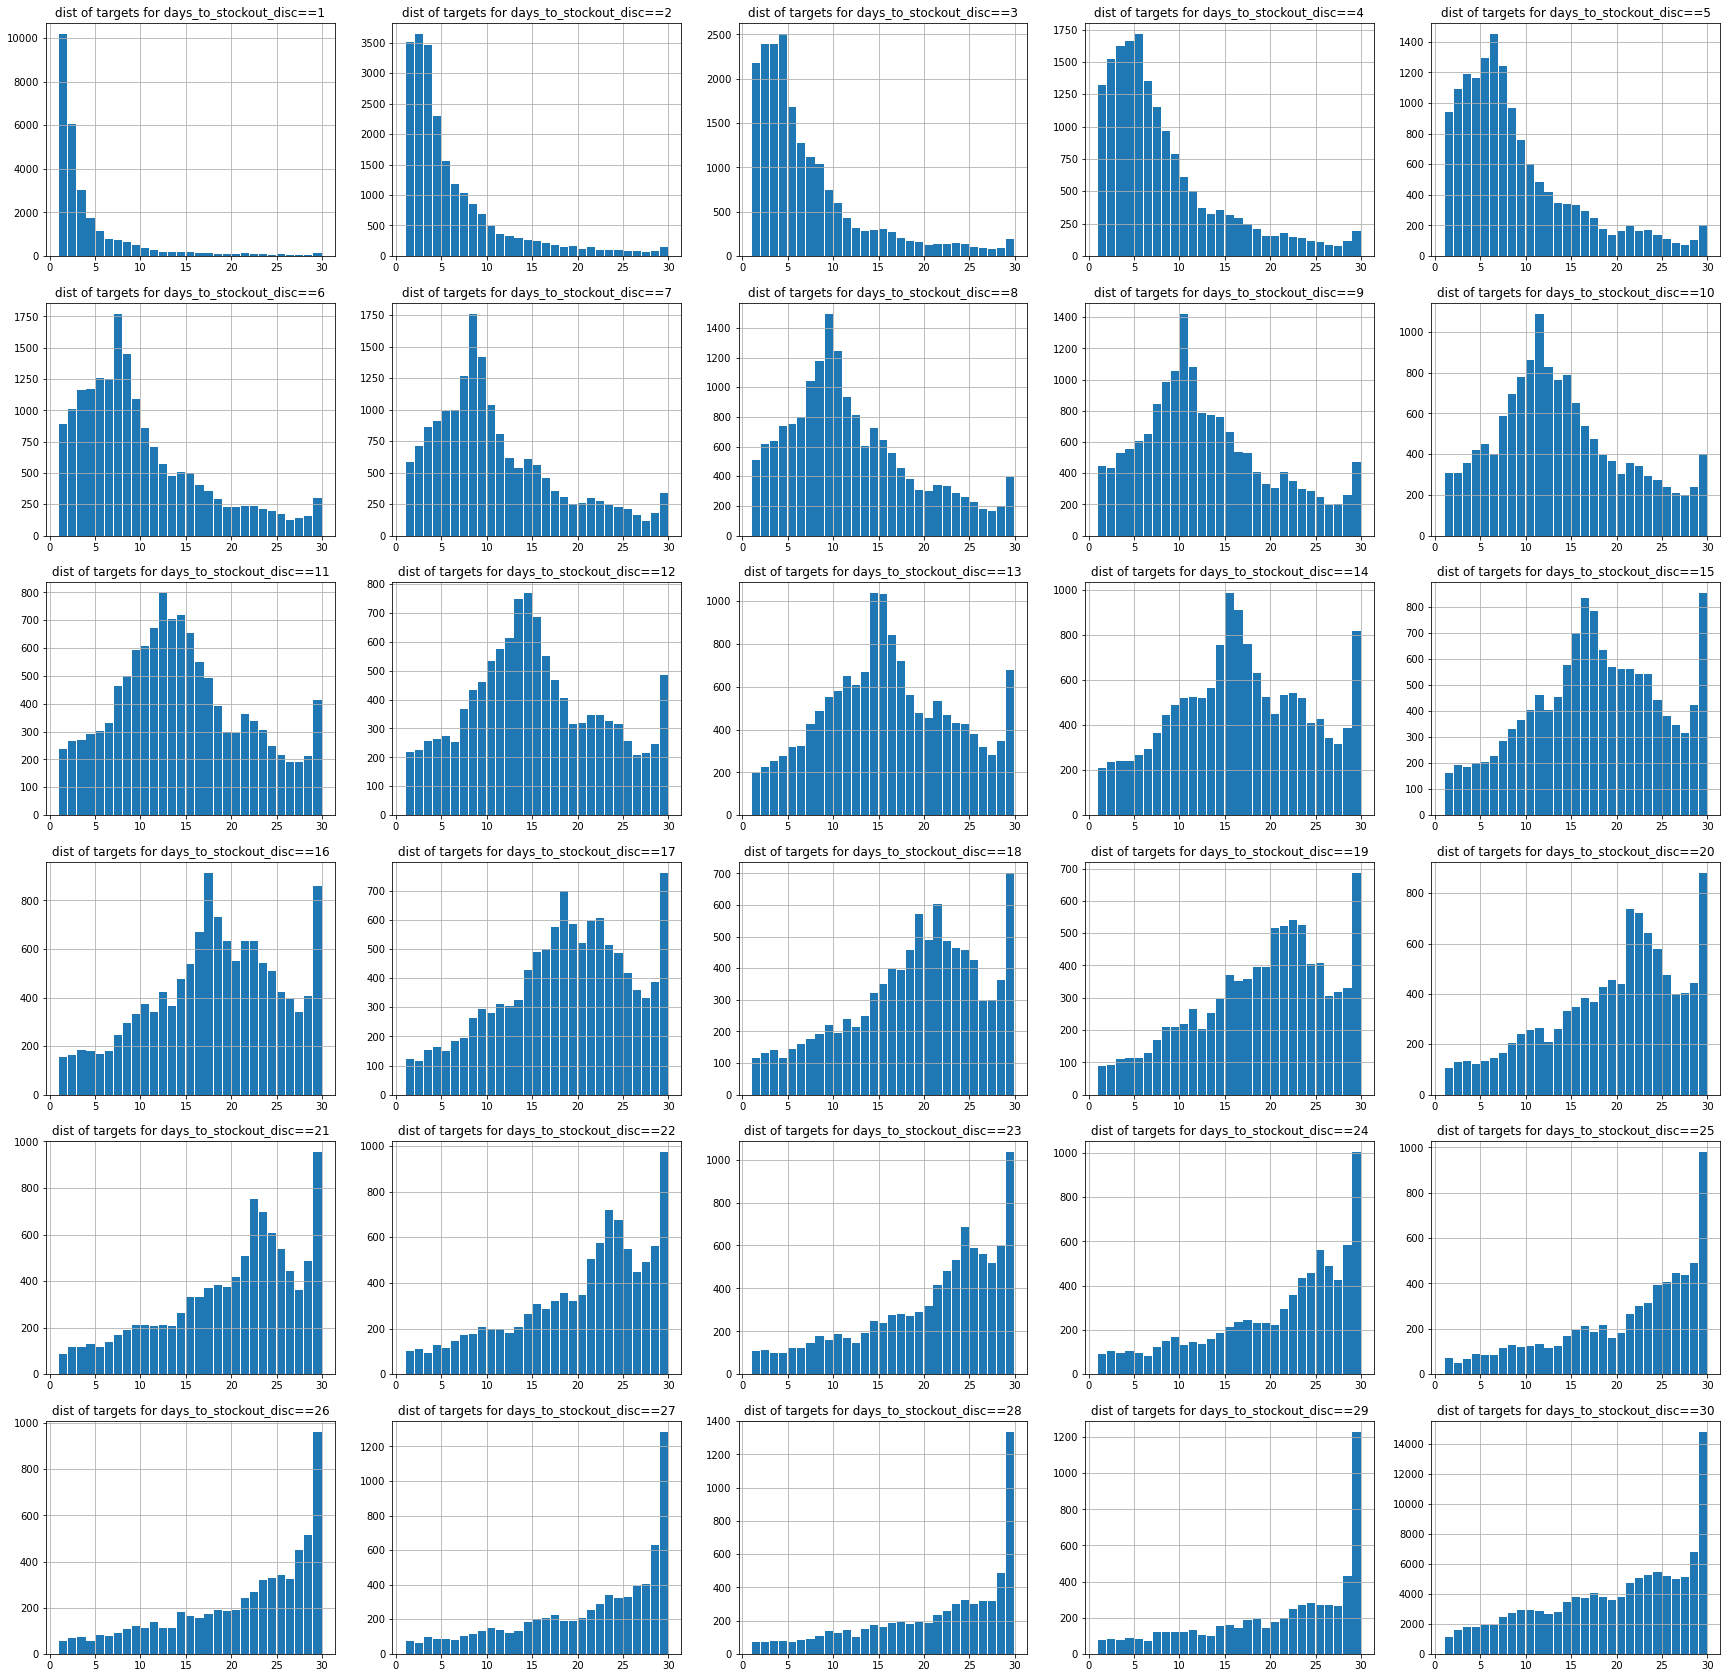

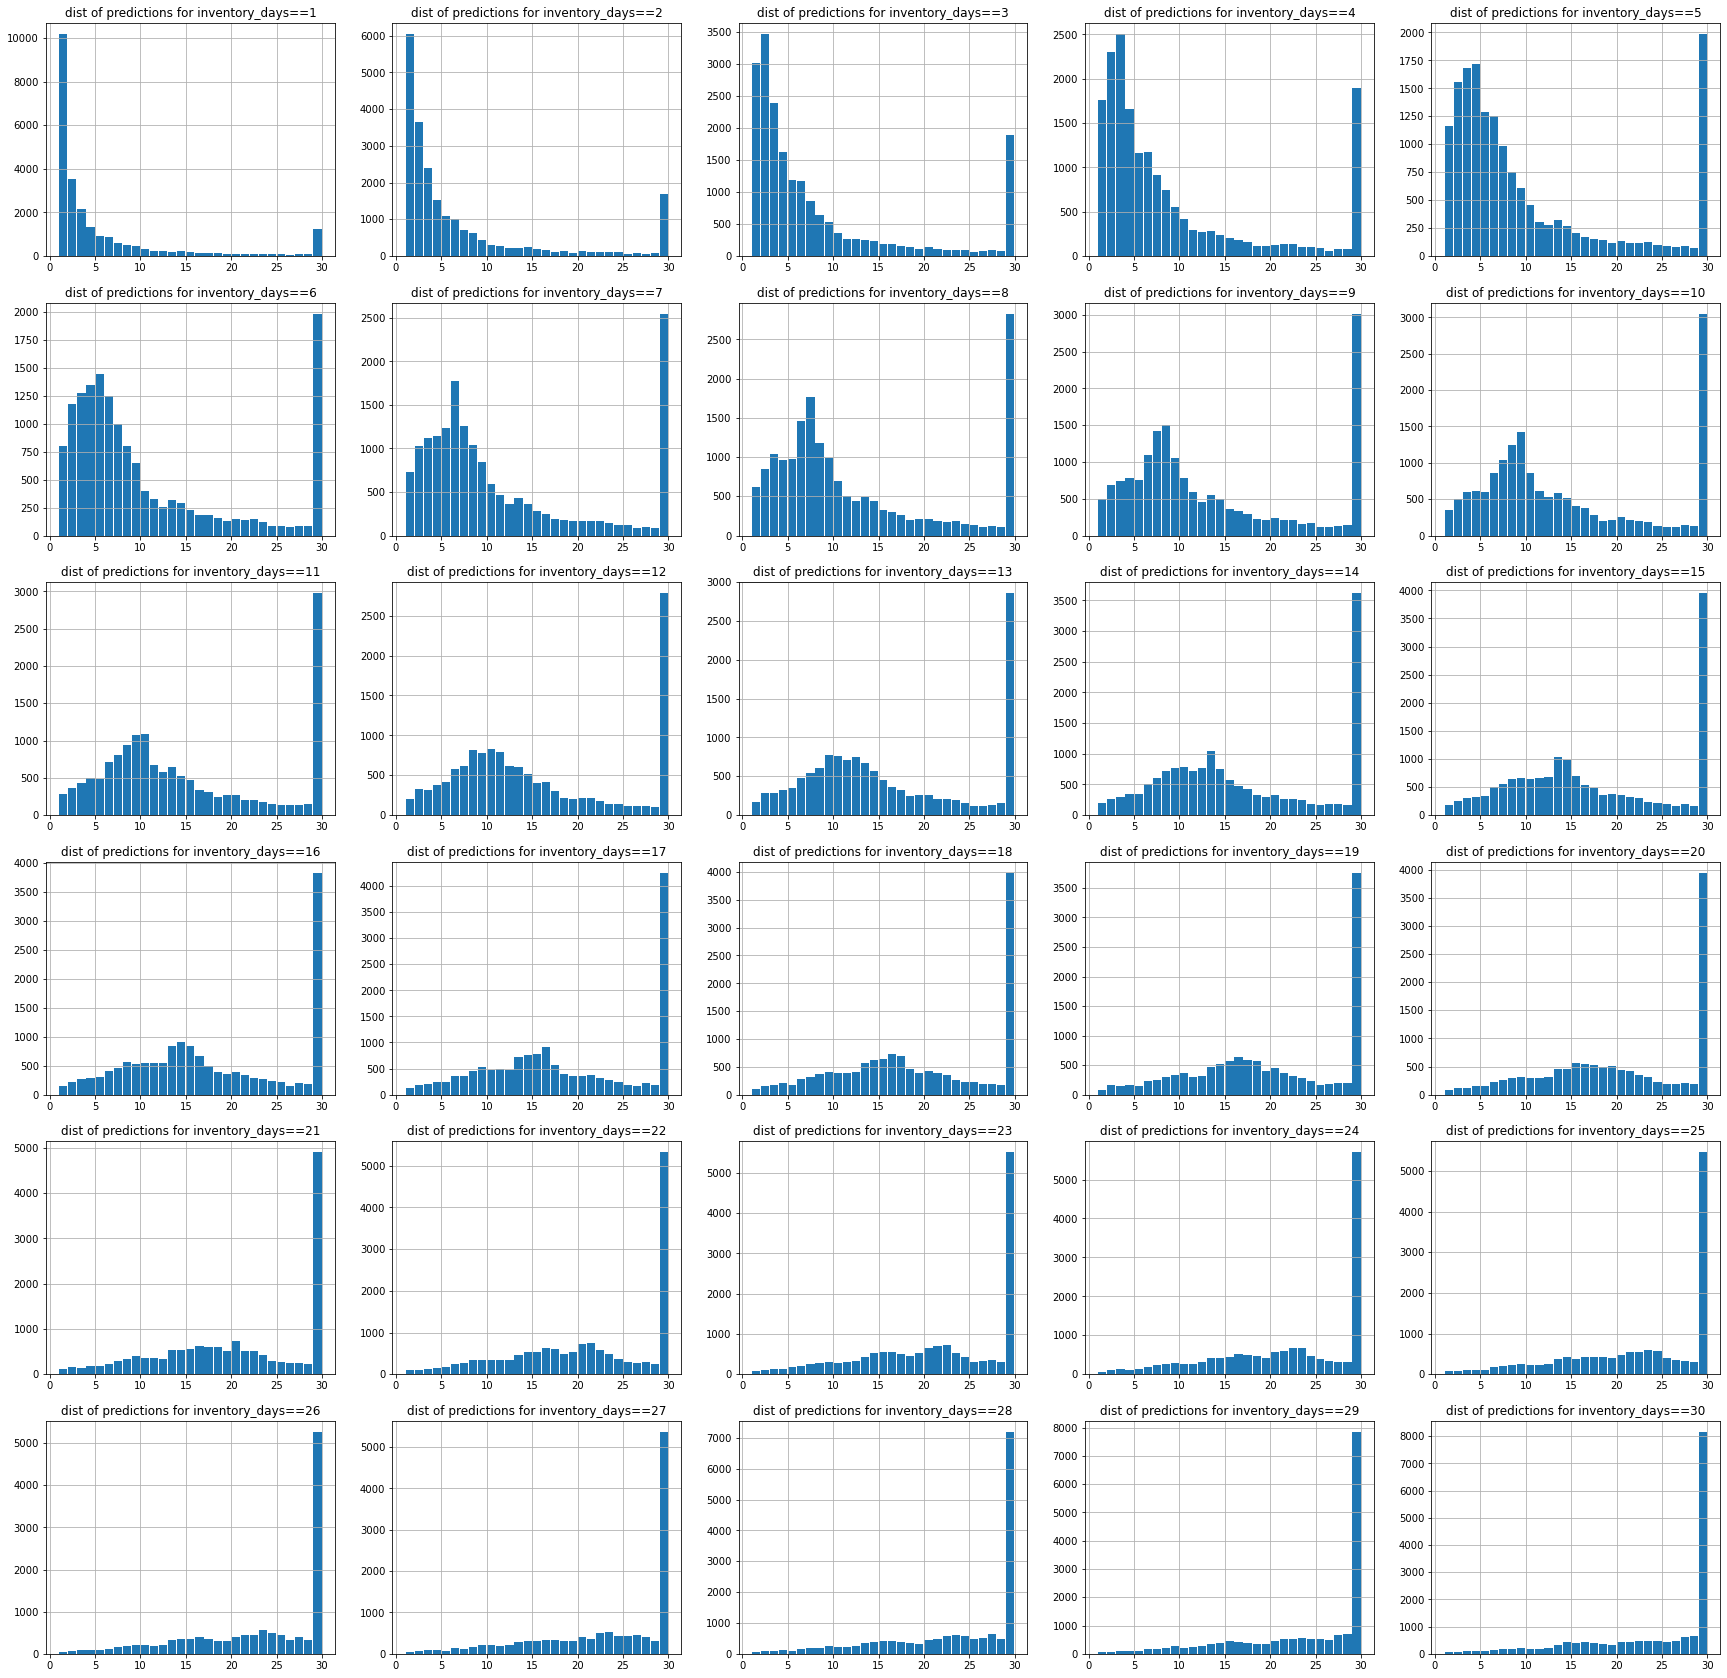

In [21]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("inventory_days <= 31").inventory_days, 
         valid.query("inventory_days <= 31").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("days_to_stockout_disc==@d").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("inventory_days==@d").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

RMSE (mean):  8.491960059510582
MAE (mean):  6.140954809822006
MAE (median):  4.231650791267944



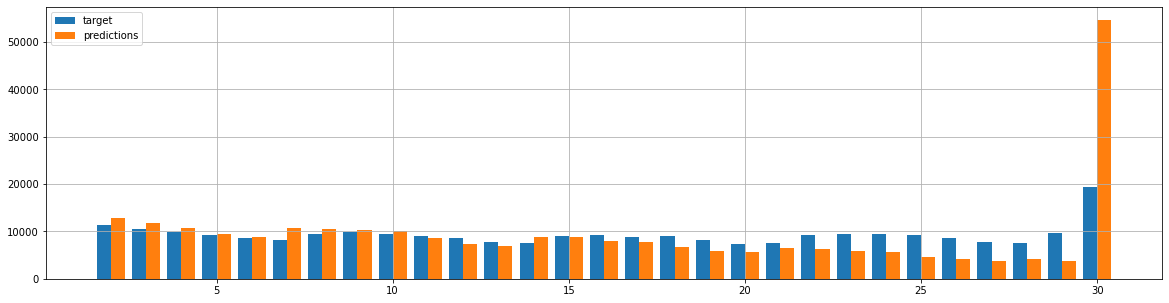

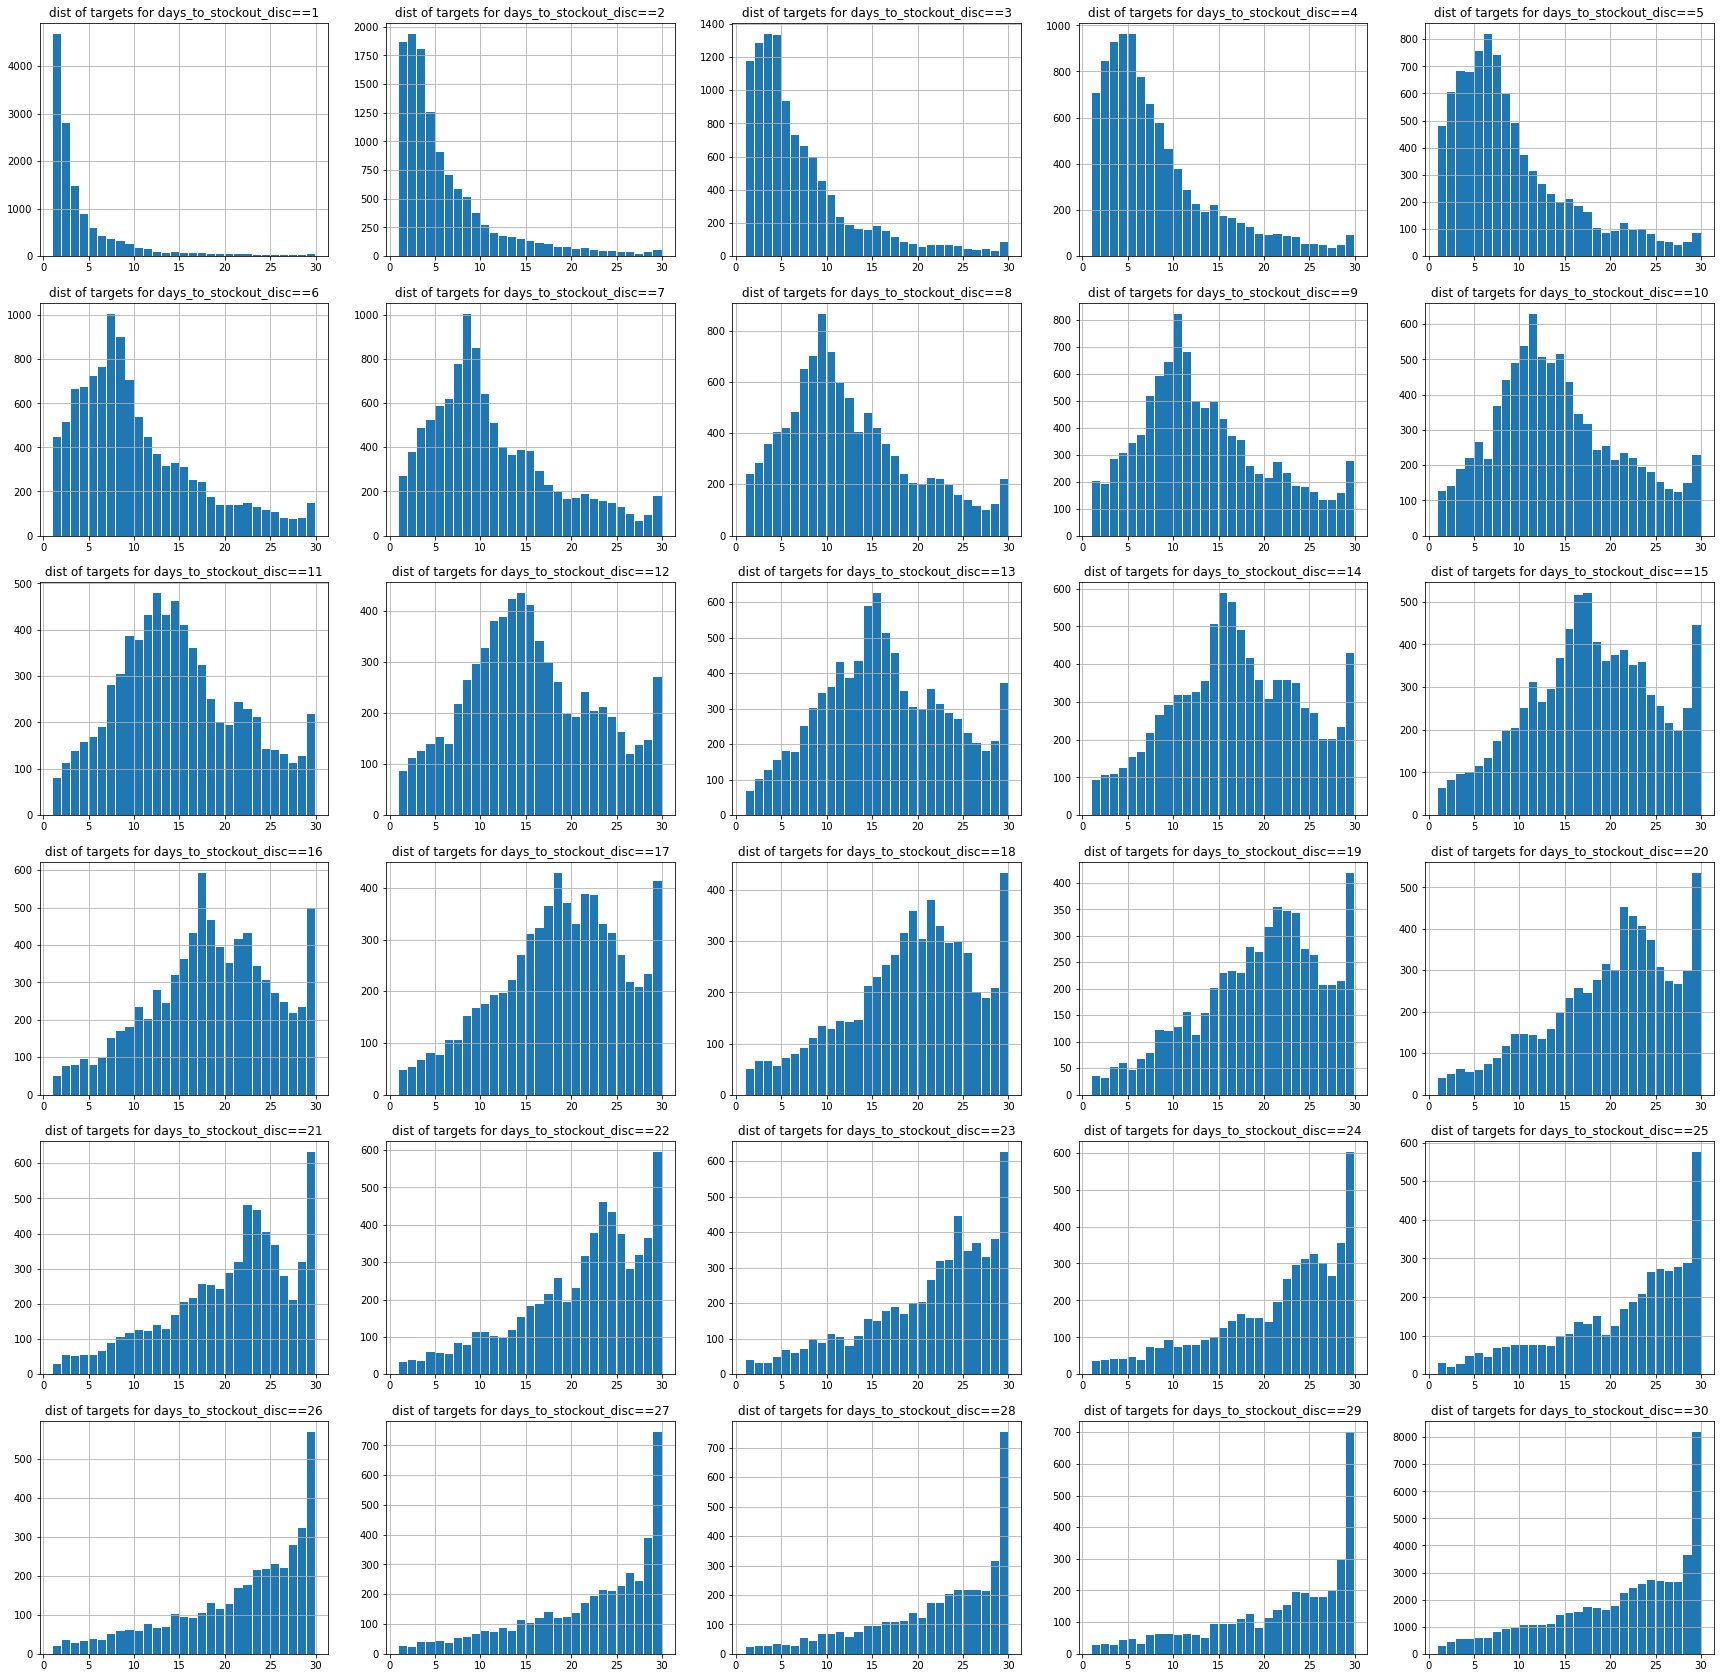

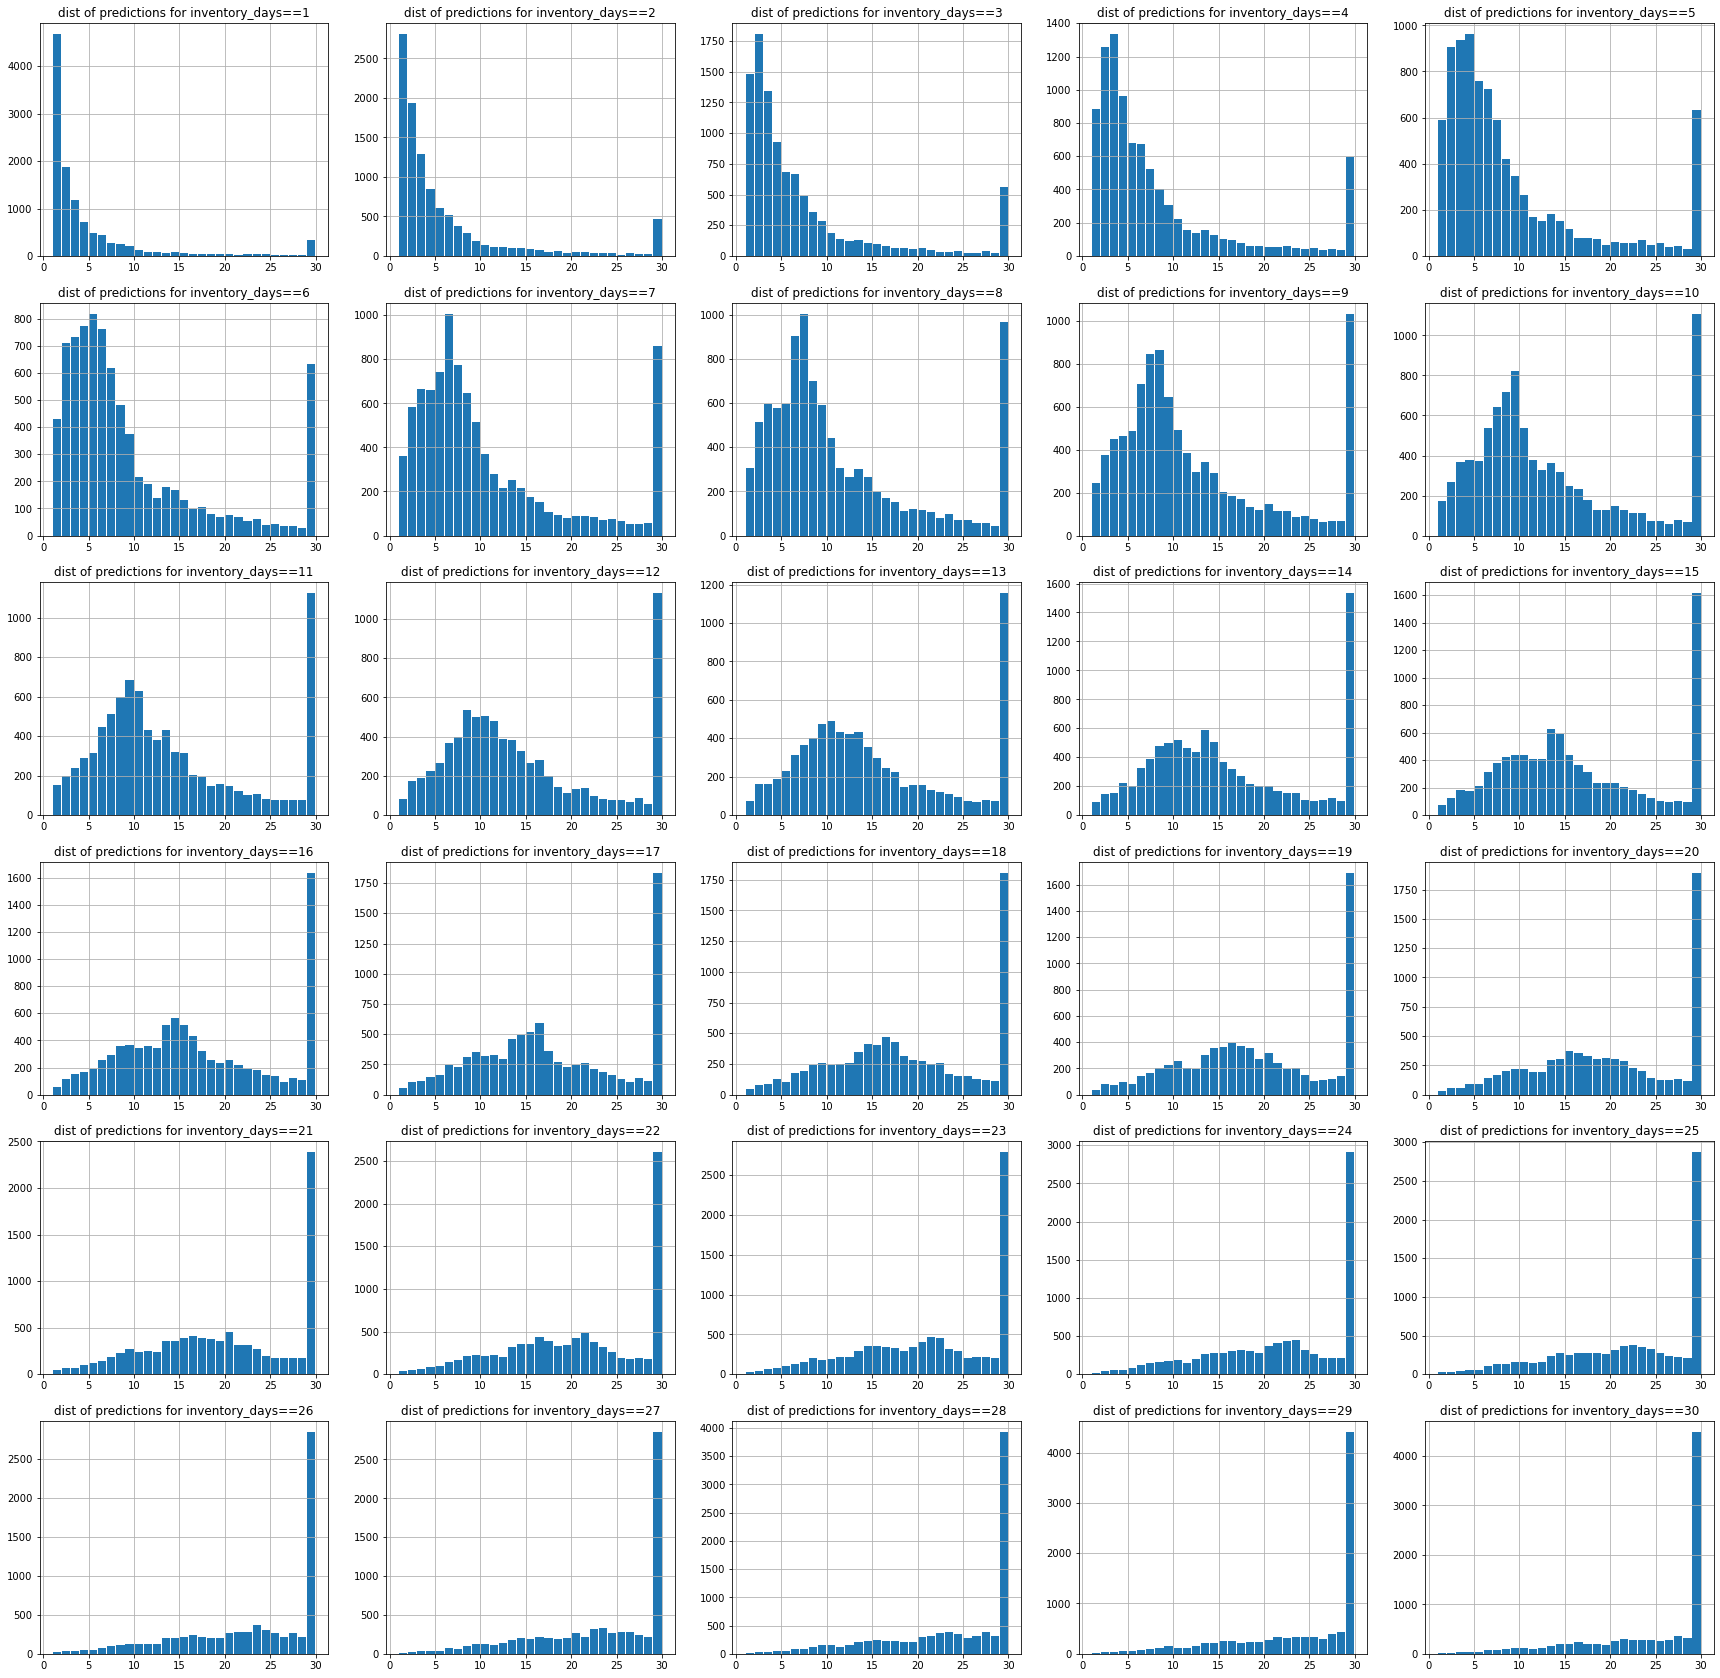

In [22]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("sku in @skus_assess_m2").inventory_days, 
         valid.query("sku in @skus_assess_m2").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(days_to_stockout_disc == @d) & (sku in @skus_assess_m2)").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(inventory_days == @d) & (sku in @skus_assess_m2)").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

***
## Assessment of RPS

In [23]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if "seed2.csv" not in fn]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_assess_m1")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                dist_kwargs={"beta":dist_config["beta"]},
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 482635/482635 [02:19<00:00, 3465.87it/s]


{'file': 'validation_seed19', 'rps': 3.9015341708829996}


100%|██████████| 482635/482635 [02:16<00:00, 3529.23it/s]


{'file': 'validation_seed23', 'rps': 3.900657656644922}


100%|██████████| 482635/482635 [02:17<00:00, 3505.67it/s]


{'file': 'validation_seed2_harder', 'rps': 4.021300393763792}


100%|██████████| 324347/324347 [01:32<00:00, 3517.81it/s]


{'file': 'validation_realstock', 'rps': 3.5151054177950756}


100%|██████████| 482635/482635 [02:17<00:00, 3516.60it/s]


{'file': 'validation_seed17_harder', 'rps': 4.022489258106122}


100%|██████████| 482635/482635 [02:17<00:00, 3516.88it/s]


{'file': 'validation_seed19_harder', 'rps': 4.0235643411140725}


100%|██████████| 482635/482635 [02:17<00:00, 3510.78it/s]


{'file': 'validation_seed23_harder', 'rps': 4.022334905001319}


100%|██████████| 482635/482635 [02:16<00:00, 3523.97it/s]


{'file': 'validation_seed17', 'rps': 3.90410283206157}


In [24]:
if ASSESS:
    display(pd.DataFrame(results))
    
    # cleanup ram
    del models_by_site
    gc.collect()

,file,rps
0,validation_seed19,3.901534
1,validation_seed23,3.900658
2,validation_seed2_harder,4.021300
3,validation_realstock,3.515105
4,validation_seed17_harder,4.022489
5,validation_seed19_harder,4.023564
6,validation_seed23_harder,4.022335
7,validation_seed17,3.904103


***
## model training

In [25]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 30.218544
nskus: 526189


In [26]:
test = (
    pd.read_parquet(f"{input_path}/test-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


In [27]:
raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")

# compute q_mean and q_std features (w/o leakage)
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")
dataset = feat.transform(dataset)
test = feat.transform(test)

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 240.05 Mb (52.0% reduction)
Elapsed time for processing features: 0.7647768298784892 min.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 2621983, number of used features: 21


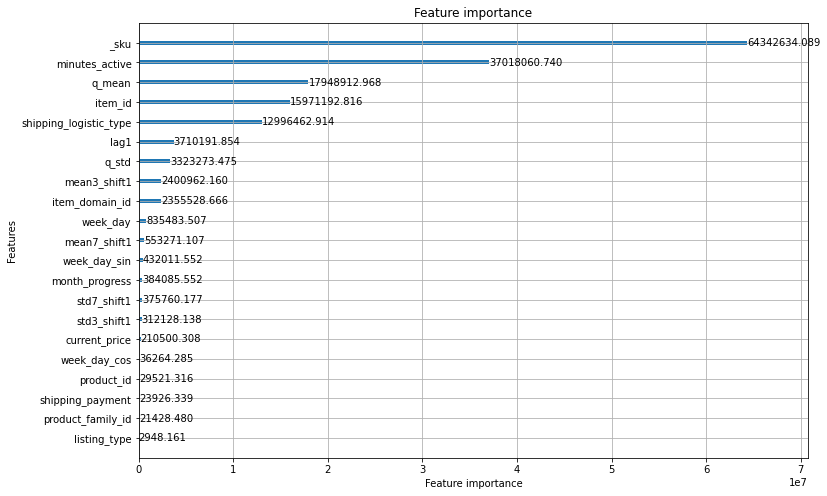

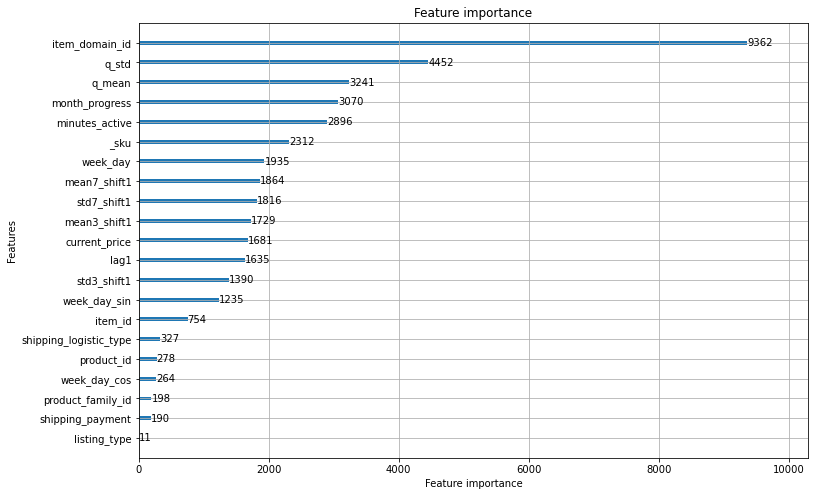

Elapsed time for training the model: 0.39876925150553383 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1446.41 Mb (51.0% reduction)
Elapsed time for processing features: 3.57201486825943 min.
[LightGBM] [Info] Total Bins 3162
[LightGBM] [Info] Number of data points in the train set: 15476240, number of used features: 21


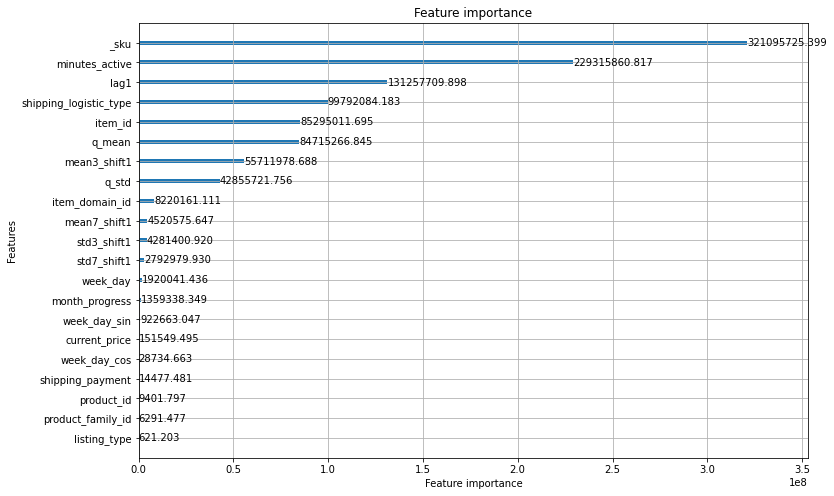

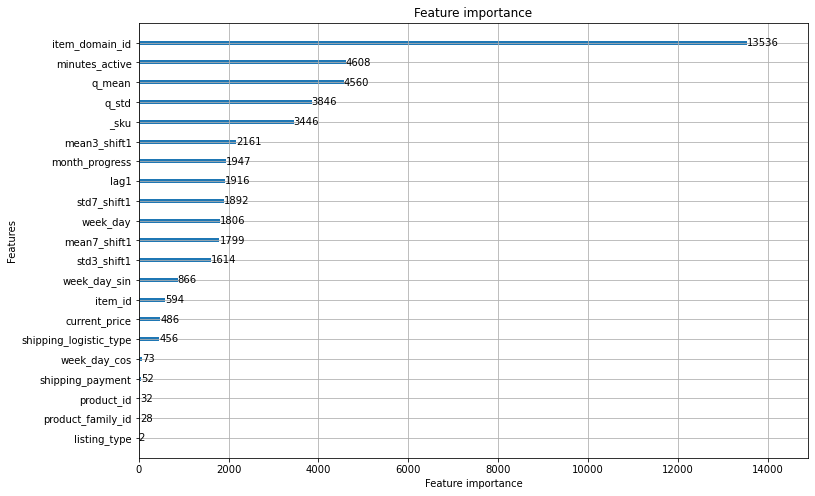

Elapsed time for training the model: 2.302674166361491 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1109.65 Mb (52.0% reduction)
Elapsed time for processing features: 2.8050490657488507 min.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 12120321, number of used features: 21


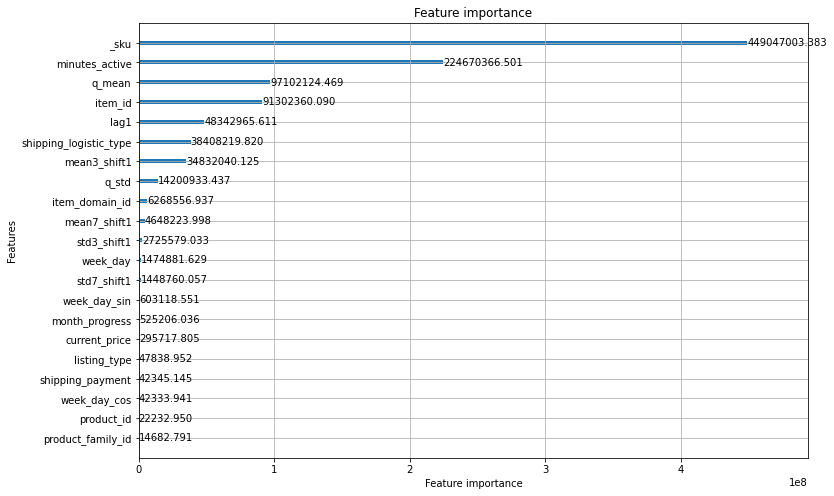

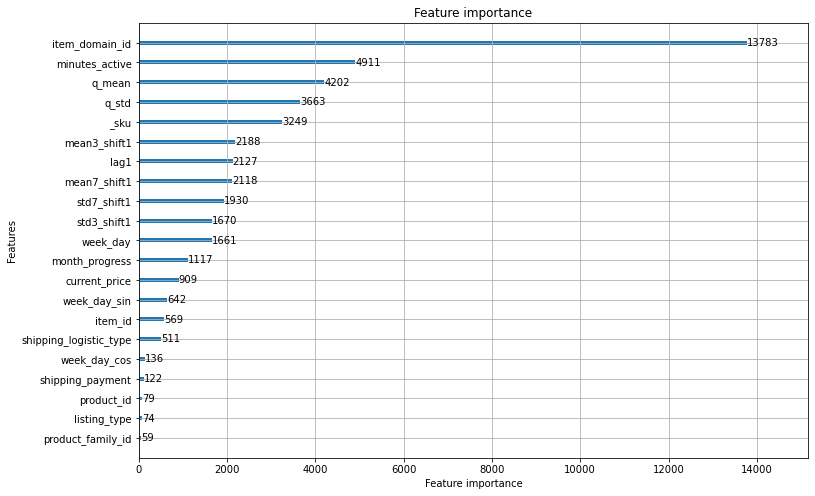

Elapsed time for training the model: 1.8329899191856385 min.


In [28]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 160,
    "MLB": 180,
    "MLM": 180,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [29]:
# calculates fit stats on train dataset
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site"))
    all_preds.append(preds)
train_preds = pd.concat(all_preds, axis=0, ignore_index=True)
train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])

train_preds["abs_error"] = train_preds.eval("abs(y-y_pred)")
train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
train_preds["residual"] = train_preds.eval("(y-y_pred)")

rmse = np.sqrt(train_preds.groupby(["sku"])["sq_error"].mean()).reset_index(name="rmse")
mean_ae = train_preds.groupby(["sku"])["abs_error"].mean().reset_index(name="mean_ae")
median_ae = train_preds.groupby(["sku"])["abs_error"].median().reset_index(name="median_ae")
residual_std = train_preds.groupby(["sku"])["residual"].std().reset_index(name="residual_std")
residual_mad = train_preds.groupby(["sku"])["residual"].mad().reset_index(name="residual_mad")

fit_stats = (
    rmse
    .merge(mean_ae, how="inner", on="sku")
    .merge(median_ae, how="inner", on="sku")
    .merge(residual_std, how="inner", on="sku")
    .merge(residual_mad, how="inner", on="sku")
    .merge(scales, how="inner", on="sku")
    .merge(dataset[["sku","site_id","q_mean"]].drop_duplicates(subset=["sku"]), how="inner", on="sku")
)
fit_stats["rmsse"] = fit_stats.eval("rmse / scale")
fit_stats["rmse_norm"] = fit_stats.eval("rmse / q_mean")
fit_stats["mean_ae_norm"] = fit_stats.eval("mean_ae / q_mean")
fit_stats["median_ae_norm"] = fit_stats.eval("median_ae / q_mean")
fit_stats["residual_std_norm"] = fit_stats.eval("residual_std / q_mean")
fit_stats["residual_mad_norm"] = fit_stats.eval("residual_mad / q_mean")
fit_stats["scale_norm"] = fit_stats.eval("scale / q_mean")
display(fit_stats.groupby("site_id")["rmsse"].mean())

fit_stats.to_csv(f"{results_path}/train_errors_lgbm-m1-stg2.csv", index=False)

site_id
MLA    0.731853
MLB    0.771898
MLM    0.748529
Name: rmsse, dtype: float64

In [30]:
# compute predictions on test period
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)
    
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

3it [28:25, 568.37s/it]


In [31]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526189/526189 [01:08<00:00, 7666.87it/s]


100%|██████████| 526189/526189 [01:07<00:00, 7819.57it/s]


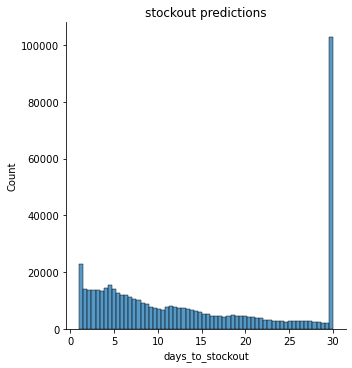

In [32]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

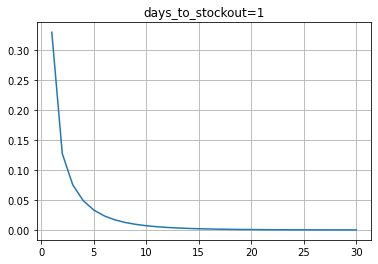

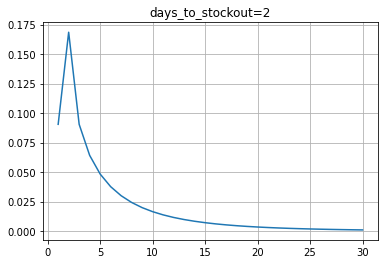

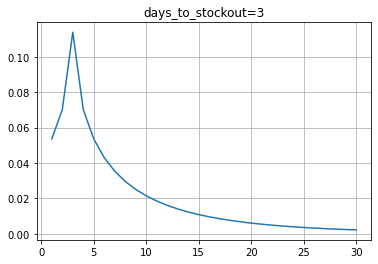

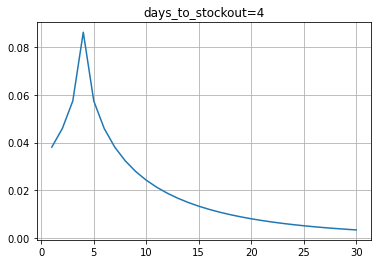

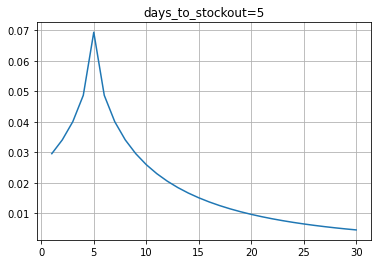

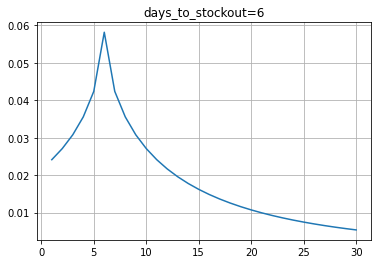

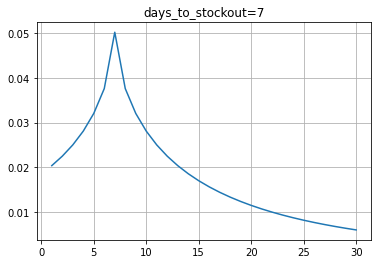

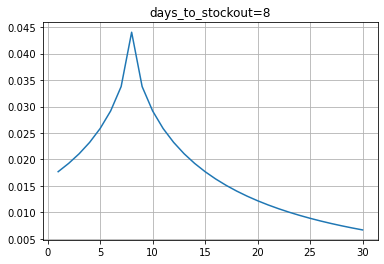

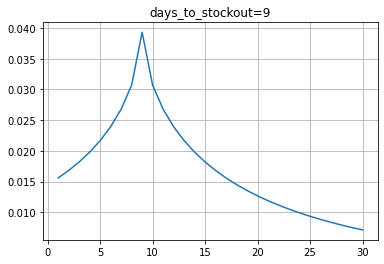

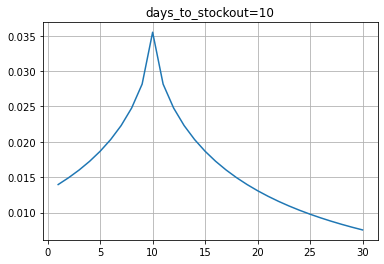

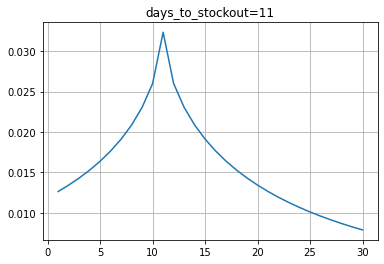

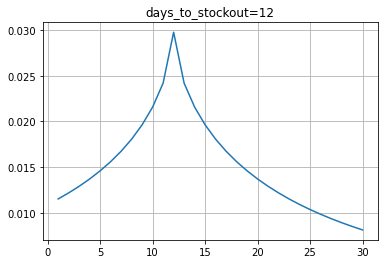

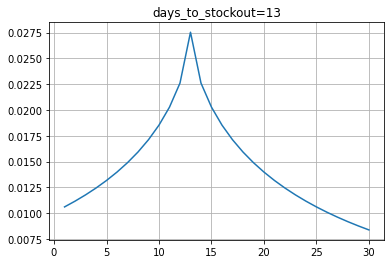

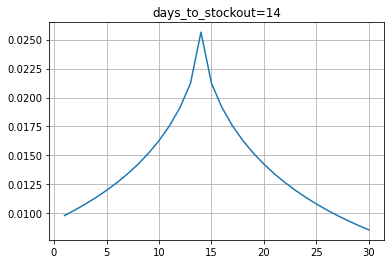

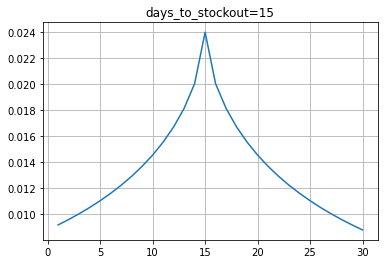

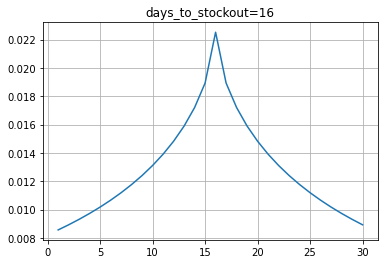

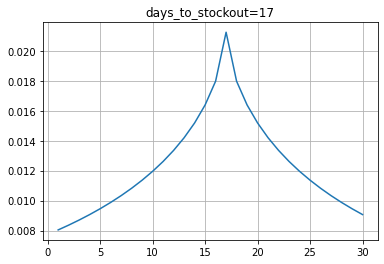

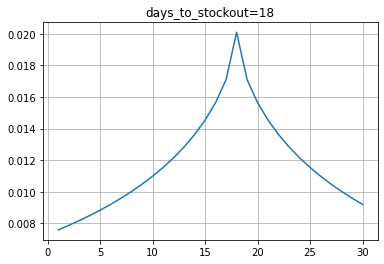

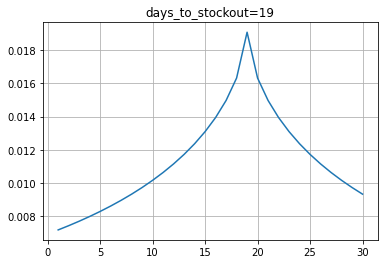

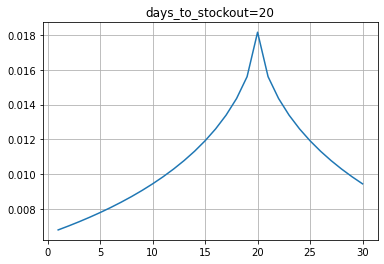

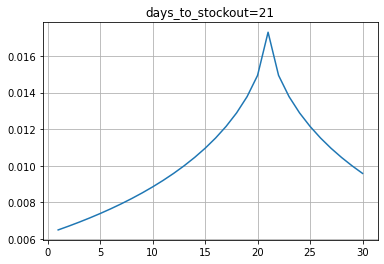

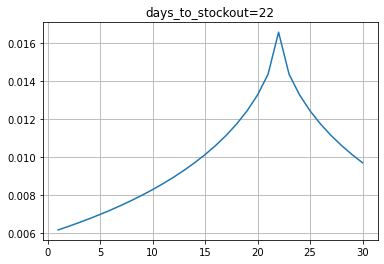

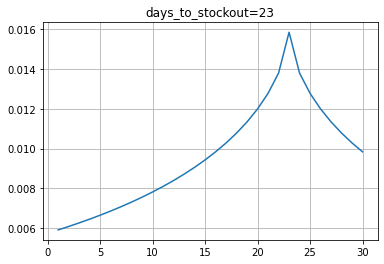

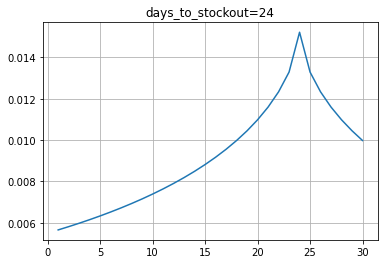

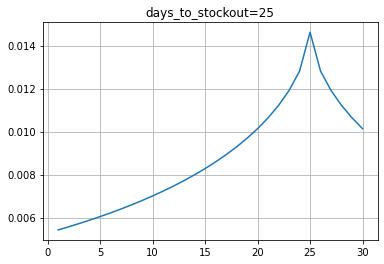

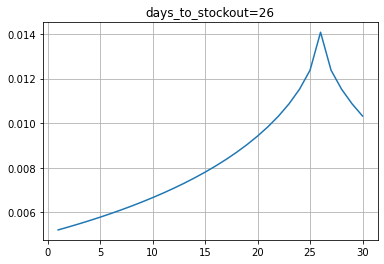

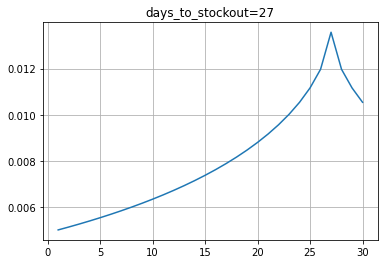

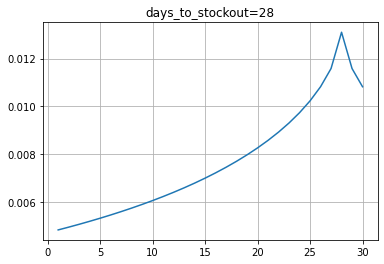

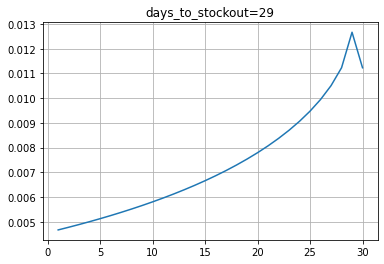

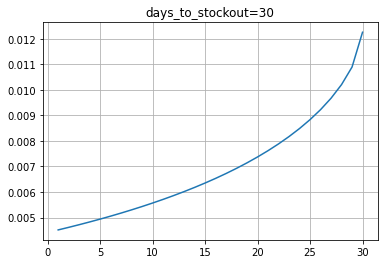

In [33]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=dist_config["beta"])
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [34]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":dist_config["beta"]},
        lambda1=dist_config["lambda1"], 
        lambda2=dist_config["lambda2"],
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526189/526189 [02:42<00:00, 3236.41it/s]


In [35]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.068653,0.082662,0.107404,0.093046,0.075227,0.063496,0.054771,0.047908,0.042327,0.037685,0.033760,0.030397,0.027488,0.024949,0.022719,0.020747,0.018996,0.017432,0.016031,0.014771,0.013634,0.012606,0.011672,0.010823,0.010049,0.009342,0.008695,0.008101,0.007556,0.007054
1,0.021388,0.022351,0.023385,0.024497,0.025700,0.027004,0.028426,0.029986,0.031710,0.033632,0.035799,0.038283,0.041196,0.044743,0.049385,0.057219,0.051117,0.045954,0.042156,0.039085,0.036490,0.034238,0.032250,0.030473,0.028868,0.027408,0.026070,0.024840,0.023702,0.022646
2,0.025573,0.025934,0.026305,0.026686,0.027078,0.027482,0.027898,0.028328,0.028771,0.029229,0.029704,0.030195,0.030705,0.031235,0.031786,0.032362,0.032963,0.033593,0.034256,0.034954,0.035694,0.036481,0.037323,0.038232,0.039222,0.040317,0.041554,0.043000,0.044822,0.048319
3,0.026844,0.028444,0.030213,0.032183,0.034397,0.036919,0.039840,0.043311,0.047609,0.053396,0.065434,0.053434,0.047636,0.043332,0.039857,0.036933,0.034410,0.032194,0.030223,0.028454,0.026852,0.025394,0.024058,0.022830,0.021696,0.020646,0.019670,0.018761,0.017911,0.017116
5,0.020317,0.020837,0.021379,0.021943,0.022531,0.023145,0.023787,0.024458,0.025161,0.025899,0.026675,0.027491,0.028353,0.029265,0.030232,0.031260,0.032358,0.033535,0.034802,0.036174,0.037672,0.039321,0.041160,0.043245,0.045673,0.048630,0.052630,0.055104,0.050127,0.046835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [36]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [37]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [38]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***